In [2]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
from io import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [3]:
BP = "./"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [4]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' \
                        type=\"audio/wav\"></audio>".format(url))

In [5]:
# sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
sound_file = "./short_206377.wav"
y, sr = librosa.load(sound_file, duration=5.0)

Audio(url=sound_file)

# Sound as 1D-Signal

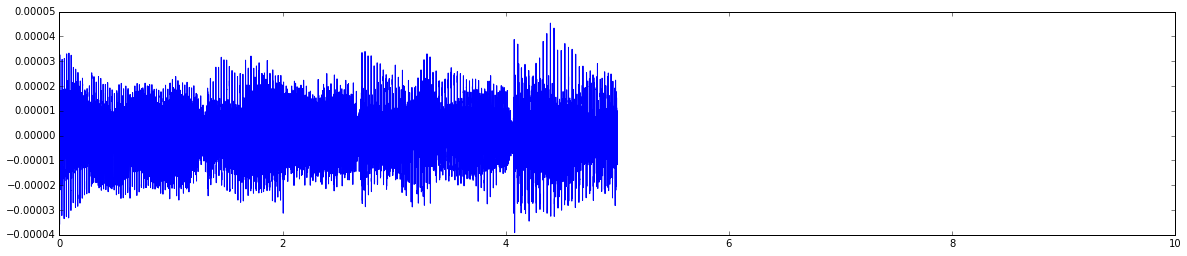

In [6]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(y.shape[0]) * float(1)/sr, y * float(1)/sr)
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [7]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

Нарисуйте спектрограмму, получилась красивая картинка?

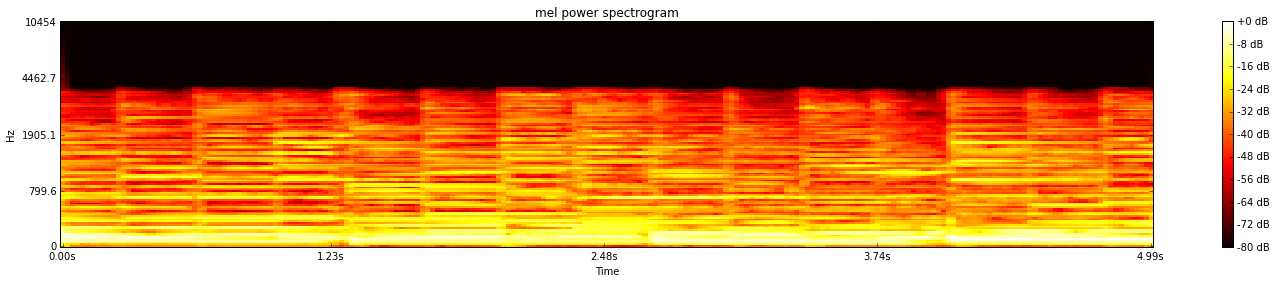

In [8]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

Считываем тренировочную выборку (для дз тестовая не нужна):

In [9]:
import numpy as np
# X = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl")) --- что это???
X = []
for i in range(1,7):
    X.append(np.load(os.path.join("spectrograms", "spectrograms%d.pcl" % i)))
X = np.vstack(X)

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [10]:
import pandas as pd
train_genres_pandas = pd.read_csv('train_genres.txt', header=None)
train_genres = pd.read_csv('train_genres.txt', header=None).values.ravel()

train_genres_pandas.head()

,0
0,bard
1,dance
2,relax
3,rock
4,rap


In [11]:
num_classes = len(set(train_genres))

In [12]:
y = np.array(train_genres)

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

Разобьем датасет на трейн и валидацию 80/20%.

In [52]:
Xreshape = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

In [53]:
from sklearn.cross_validation import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(Xreshape, y, test_size=0.2, random_state=239)

Попробуем поклассифицировать жанры методом ближайших соседей.

In [54]:
%%time
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1001, algorithm='ball_tree', weights='distance')
clf = clf.fit(X_tr, y_tr)

CPU times: user 1min 46s, sys: 1.96 s, total: 1min 48s
Wall time: 1min 48s


In [55]:
%%time
y_pred = clf.predict(X_val)

CPU times: user 28min 43s, sys: 0 ns, total: 28min 43s
Wall time: 28min 43s


In [56]:
print 'accuracy:', accuracy_score(y_pred, y_val) 

accuracy: 0.360833333333


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [7]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

Перемешаем и разобьем датасет.

In [8]:
X = []
for i in range(1,7):
    X.append(np.load(os.path.join(BP, "spectrograms", "spectrograms%d.pcl" % i)))
X = np.vstack(X)

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

In [ ]:
name_to_num = {}
inx = 1
for i in range(len(y)):
    if y[i] not in name_to_num:
        name_to_num[y[i]] = inx
        inx += 1

for i in range(len(y)):
    y[i] = name_to_num[y[i]]

In [10]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

#### А почему нельзя было использовать train_test_split???

In [13]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2], X.shape[3]), input_var=input_X) 

nn = lasagne.layers.DenseLayer(nn, 128, 
                                    nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.DenseLayer(nn, 128, 
                                    nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.DenseLayer(nn, 67, 
                                    nonlinearity=lasagne.nonlinearities.softmax)

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.sgd(loss, all_weights, learning_rate=0.8)

In [14]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], 
                            allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], 
                            allow_input_downcast=True)

In [15]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, \
                          X_valid, y_valid, num_epochs=10, batch_size=50)

Epoch   1 of  10 train_loss = 430.78 val_loss = 3.85 train_acc = 19.43 val_acc = 34.00
Epoch   2 of  10 train_loss = 3.35 val_loss = 2.97 train_acc = 35.24 val_acc = 34.00
Epoch   3 of  10 train_loss = 2.78 val_loss = 2.71 train_acc = 35.24 val_acc = 34.00
Epoch   4 of  10 train_loss = 2.66 val_loss = 2.68 train_acc = 35.24 val_acc = 34.00
Epoch   5 of  10 train_loss = 2.65 val_loss = 2.68 train_acc = 35.24 val_acc = 34.00
Epoch   6 of  10 train_loss = 2.65 val_loss = 2.67 train_acc = 35.24 val_acc = 34.00
Epoch   7 of  10 train_loss = 2.64 val_loss = 2.67 train_acc = 35.24 val_acc = 34.00
Epoch   8 of  10 train_loss = 2.64 val_loss = 2.67 train_acc = 35.24 val_acc = 34.00
Epoch   9 of  10 train_loss = 2.64 val_loss = 2.67 train_acc = 35.24 val_acc = 34.00
Epoch  10 of  10 train_loss = 2.64 val_loss = 2.67 train_acc = 35.24 val_acc = 34.00
CPU times: user 18min 37s, sys: 1h 19min 5s, total: 1h 37min 42s
Wall time: 10min 20s


# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [19]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

In [27]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
y_train, y_valid = y[:10000], y[10000:]

In [21]:
input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.Conv1DLayer(nn, 128, 4, 
                                nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.MaxPool1DLayer(nn, 4)
nn = lasagne.layers.Conv1DLayer(nn, 64, 4, 
                                nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.MaxPool1DLayer(nn, 2)

nn = lasagne.layers.DenseLayer(nn, num_classes, 
                               nonlinearity=lasagne.nonlinearities.softmax)

In [22]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [40]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], 
                            allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], 
                            allow_input_downcast=True)

In [34]:
#Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=64)

Epoch   1 of  10 train_loss = 3.01 val_loss = 2.98 train_acc = 34.80 val_acc = 36.19
Epoch   2 of  10 train_loss = 2.96 val_loss = 2.93 train_acc = 34.80 val_acc = 36.14
Epoch   3 of  10 train_loss = 2.91 val_loss = 2.88 train_acc = 34.81 val_acc = 36.39
Epoch   4 of  10 train_loss = 2.87 val_loss = 2.84 train_acc = 34.80 val_acc = 36.29
Epoch   5 of  10 train_loss = 2.83 val_loss = 2.81 train_acc = 34.82 val_acc = 36.19
Epoch   6 of  10 train_loss = 2.80 val_loss = 2.78 train_acc = 34.78 val_acc = 35.99
Epoch   7 of  10 train_loss = 2.78 val_loss = 2.75 train_acc = 34.78 val_acc = 36.34
Epoch   8 of  10 train_loss = 2.75 val_loss = 2.74 train_acc = 34.80 val_acc = 36.14
Epoch   9 of  10 train_loss = 2.74 val_loss = 2.72 train_acc = 34.79 val_acc = 36.14
Epoch  10 of  10 train_loss = 2.72 val_loss = 2.70 train_acc = 34.80 val_acc = 36.24
CPU times: user 56min 23s, sys: 1h 44min 46s, total: 2h 41min 9s
Wall time: 10min 49s


Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

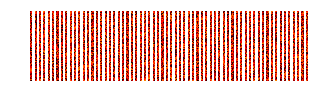

In [35]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [58]:
from sklearn.manifold import TSNE

In [59]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [60]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

In [61]:
track_vectors = track_vectors.reshape(track_vectors.shape[0], track_vectors.shape[1] * track_vectors.shape[2])

получите 2d вектора

In [62]:
model = TSNE()
X_tsne = model.fit_transform(track_vectors, y=track_labels)

нарисуйте получившиеся точки

CPU times: user 110 µs, sys: 147 µs, total: 257 µs
Wall time: 33.9 µs


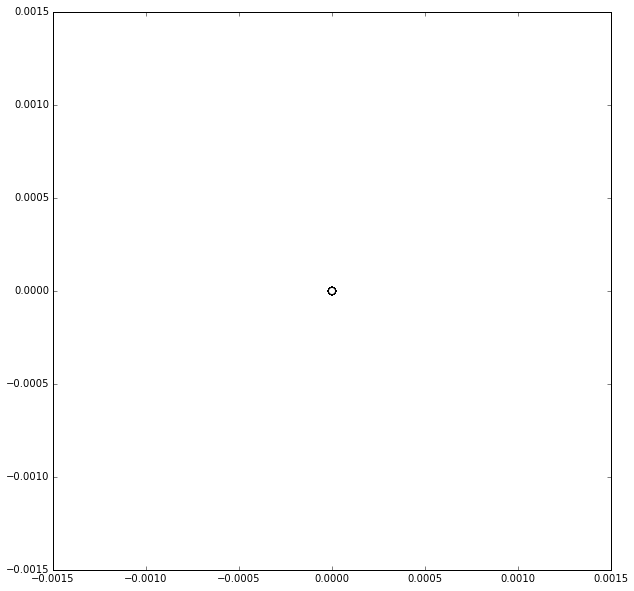

In [64]:
%time
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, num_classes))

for idx, gener in enumerate(encoder.classes_):
    idx_ = np.where(track_labels == idx)
       #  print X_tsne[idx_, 0], X_tsne[idx_, 1]
    pylab.scatter(X_tsne[idx_, 0], X_tsne[idx_, 1], c=colors[idx], cmap=cm.hot, s=50)

pylab.legend(loc=0, ncol=5)